In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sz2-dataset/s13.csv
/kaggle/input/sz2-dataset/h12.csv
/kaggle/input/sz2-dataset/h01.csv
/kaggle/input/sz2-dataset/s11.csv
/kaggle/input/sz2-dataset/h11.csv
/kaggle/input/sz2-dataset/h04.csv
/kaggle/input/sz2-dataset/s01.csv
/kaggle/input/sz2-dataset/h09.csv
/kaggle/input/sz2-dataset/s03.csv
/kaggle/input/sz2-dataset/h14.csv
/kaggle/input/sz2-dataset/h13.csv
/kaggle/input/sz2-dataset/h06.csv
/kaggle/input/sz2-dataset/s08.csv
/kaggle/input/sz2-dataset/s07.csv
/kaggle/input/sz2-dataset/s14.csv
/kaggle/input/sz2-dataset/h10.csv
/kaggle/input/sz2-dataset/h08.csv
/kaggle/input/sz2-dataset/h02.csv
/kaggle/input/sz2-dataset/h05.csv
/kaggle/input/sz2-dataset/s05.csv
/kaggle/input/sz2-dataset/h03.csv
/kaggle/input/sz2-dataset/s12.csv
/kaggle/input/sz2-dataset/h07.csv
/kaggle/input/sz2-dataset/s06.csv
/kaggle/input/sz2-dataset/s04.csv
/kaggle/input/sz2-dataset/s10.csv
/kaggle/input/sz2-dataset/s02.csv
/kaggle/input/sz2-dataset/s09.csv


In [2]:
# ============================================================
# 0) Setup & Utilities
# ============================================================
!pip -q install mne --no-warn-script-location

import os, re, warnings, gc
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

print("\nFolders under /kaggle/input:")
print(os.listdir("/kaggle/input"))

2025-11-24 16:08:28.278124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764000508.441671      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764000508.489136      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

Folders under /kaggle/input:
['sz2-dataset']


In [3]:
# 1. Check demographic file
DATA_DIR = "/kaggle/input/sz2-dataset"




# 3. Peek one subject file (say subject 1)
sample_file = os.path.join(DATA_DIR, "h01.csv")
df_sample = pd.read_csv(sample_file, nrows=5)
print("Subject 1 CSV shape:", df_sample.shape)
print("Subject 1 columns:", df_sample.columns.tolist())
print(df_sample.head())

Subject 1 CSV shape: (5, 20)
Subject 1 columns: ['time_s', 'Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4', 'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
   time_s           Fp2            F8            T4            T6  \
0   0.000  2.500000e-09  2.500000e-09  2.500000e-09  2.500000e-09   
1   0.004  2.500000e-09  2.500000e-09  2.500000e-09  2.500000e-09   
2   0.008  2.500000e-09  2.500000e-09  2.500000e-09  2.500000e-09   
3   0.012  4.612154e-07  4.612154e-07  3.083103e-07  3.083103e-07   
4   0.016  4.612154e-07  4.612154e-07  4.612154e-07  3.083103e-07   

             O2           Fp1            F7            T3            T5  \
0  2.500000e-09  2.500000e-09  2.500000e-09  2.500000e-09  2.500000e-09   
1  2.500000e-09  2.500000e-09  2.500000e-09  2.500000e-09  2.500000e-09   
2  2.500000e-09  2.500000e-09  2.500000e-09  2.500000e-09  2.500000e-09   
3  1.554051e-07  2.500000e-09  2.500000e-09 -1.504051e-07 -1.504051e-07   
4  1.554051e-07  2.500000e-09  2.50

In [4]:
import os, glob, math, random, gc, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# -------------------------
# Modified pipeline for your SZ2-style folder (28 CSVs, implicit labels)
# -------------------------

import os, glob
from scipy.signal import resample

# --- config (adjust if needed) ---
DATA_DIR = "/kaggle/input/sz2-dataset"   # folder containing 28 csv files directly
CSV_SKIP_COLS = 1        # drop first column (time)
ORIGINAL_FS = 250        # current sampling freq (assumed)
TARGET_FS = 256          # desired sampling freq (no-op if same)
SEG_SECONDS = 1
SAMPLES_PER_SEG = TARGET_FS * SEG_SECONDS
MAX_SEGS_PER_SUBJECT = None   # set small (e.g., 200) if memory is an issue
RANDOM_SEED = 42
OUT_PATH = os.path.join(DATA_DIR, "segments_labels.npz")
np.random.seed(RANDOM_SEED)
# -------------------------

# helper: infer label from filename (h* -> 0, s* -> 1), fallback by order
def infer_label_from_basename(basename, index, fallback_split=14):
    b = basename.lower()
    if b.startswith("h"):
        return 0
    if b.startswith("s"):
        return 1
    return 0 if index < fallback_split else 1

# find csv files directly in DATA_DIR
subject_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
if len(subject_files) == 0:
    raise SystemExit(f"No CSV files found in {DATA_DIR!r}")

print(f"Found {len(subject_files)} CSV files in {DATA_DIR}")

def load_and_preprocess_csv(fpath, skip_cols=CSV_SKIP_COLS, orig_fs=ORIGINAL_FS, target_fs=TARGET_FS):
    """Read CSV, drop first skip_cols columns, resample (if needed), z-score per channel.
       Returns array shape (n_samples_resampled, n_channels)"""
    df = pd.read_csv(fpath)
    if df.shape[1] <= skip_cols:
        raise ValueError(f"File {fpath} has <= {skip_cols} columns after skipping; check CSV_SKIP_COLS")
    eeg_df = df.iloc[:, skip_cols:].apply(pd.to_numeric, errors='coerce')
    # drop columns that are all NaN
    eeg_df = eeg_df.dropna(axis=1, how='all')
    arr = eeg_df.values  # (time, channels)
    # If there are any NaNs left, fill or drop -- here we fill with column mean
    if np.isnan(arr).any():
        col_mean = np.nanmean(arr, axis=0)
        inds = np.where(np.isnan(arr))
        arr[inds] = np.take(col_mean, inds[1])

    # resample if needed
    if orig_fs == target_fs:
        arr_rs = arr
    else:
        if orig_fs % target_fs == 0:
            factor = orig_fs // target_fs
            if factor == 1:
                arr_rs = arr
            else:
                arr_rs = arr[::factor, :]
        else:
            new_n = int(np.round(arr.shape[0] * (target_fs / orig_fs)))
            arr_rs = resample(arr, new_n, axis=0)

    # z-score per channel
    mu = arr_rs.mean(axis=0, keepdims=True)
    std = arr_rs.std(axis=0, keepdims=True) + 1e-8
    arr_z = (arr_rs - mu) / std
    return arr_z.astype(np.float32)

def make_segments_from_array(arr, seg_sec=SEG_SECONDS, target_fs=TARGET_FS, max_segs=None):
    samples_per_seg = int(target_fs * seg_sec)
    n_segs = arr.shape[0] // samples_per_seg
    if n_segs == 0:
        return np.zeros((0, samples_per_seg, arr.shape[1]), dtype=np.float32)
    segs = arr[: n_segs * samples_per_seg, :].reshape(n_segs, samples_per_seg, arr.shape[1])
    if (max_segs is not None) and (segs.shape[0] > max_segs):
        segs = segs[:max_segs, :, :]
    return segs.astype(np.float32)

# Build dataset
X_parts, y_parts, subj_info = [], [], []  # subj_info: (basename, n_saved, label)

for idx, fpath in enumerate(subject_files):
    basename = os.path.splitext(os.path.basename(fpath))[0]
    label = infer_label_from_basename(basename, idx, fallback_split=14)
    try:
        arr_z = load_and_preprocess_csv(fpath)
    except Exception as e:
        print(f"[skip] {basename}: failed to load/preprocess ({e})")
        continue

    segs = make_segments_from_array(arr_z, seg_sec=SEG_SECONDS, target_fs=TARGET_FS, max_segs=MAX_SEGS_PER_SUBJECT)
    if segs.shape[0] == 0:
        print(f"[skip] {basename}: too short to form any {SEG_SECONDS}s segments")
        continue

    n_saved = segs.shape[0]
    X_parts.append(segs)                       # (n_segs, samples_per_seg, n_channels)
    y_parts.append(np.full((n_saved,), label, dtype=np.int64))
    subj_info.append((basename, n_saved, label))

    print(f"{basename}: segments={n_saved}, channels={segs.shape[2]}, label={label}")

# concatenate
if len(X_parts) == 0:
    raise RuntimeError("No segments created. Check CSV files and CSV_SKIP_COLS setting.")

X = np.concatenate(X_parts, axis=0)   # (total_segs, samples_per_seg, n_channels)
y = np.concatenate(y_parts, axis=0)
subjects_for_segments = np.concatenate([[name]*n for (name,n,lab) in subj_info])

print(f"\nTOTAL segments: {X.shape[0]}, per-seg shape: {X.shape[1:]}")
print("Class counts:", np.bincount(y))

# Convert to GENet input shape: (N, samples_per_seg, n_channels, 1)
X_genet = X[..., np.newaxis]
print("GENet input shape:", X_genet.shape)

# one-hot labels for training (if needed)
y_cat = to_categorical(y, num_classes=2)

# save compressed file
np.savez_compressed(OUT_PATH, X=X_genet, y=y, y_cat=y_cat, subjects=subj_info)
print("Saved dataset to", OUT_PATH)

Found 28 CSV files in /kaggle/input/sz2-dataset
h01: segments=925, channels=19, label=0
h02: segments=910, channels=19, label=0
h03: segments=910, channels=19, label=0
h04: segments=925, channels=19, label=0
h05: segments=945, channels=19, label=0
h06: segments=930, channels=19, label=0
h07: segments=910, channels=19, label=0
h08: segments=910, channels=19, label=0
h09: segments=905, channels=19, label=0
h10: segments=1115, channels=19, label=0
h11: segments=915, channels=19, label=0
h12: segments=900, channels=19, label=0
h13: segments=965, channels=19, label=0
h14: segments=865, channels=19, label=0
s01: segments=845, channels=19, label=1
s02: segments=1145, channels=19, label=1
s03: segments=964, channels=19, label=1
s04: segments=1205, channels=19, label=1
s05: segments=890, channels=19, label=1
s06: segments=740, channels=19, label=1
s07: segments=1346, channels=19, label=1
s08: segments=911, channels=19, label=1
s09: segments=1185, channels=19, label=1
s10: segments=850, channels

OSError: [Errno 30] Read-only file system: '/kaggle/input/sz2-dataset/segments_labels.npz'

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Ensure all data variables are available: X_genet (N, 256, 19, 1), y, subjects_for_segments
# RANDOM_SEED is assumed to be defined.

batch_size = 64
n_classes = 2

# --- Model Architecture (High-Capacity GENet) ---
def build_genet_model(input_shape, n_classes=2):
    # Using the high-capacity filter counts to match complexity
    model = Sequential([
        # === Block 1: Filters 32 (was 16) ===
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(1, 2), strides=(2, 2)), 
        Dropout(0.25),

        # === Block 2: Filters 64 (was 32) ===
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), 
        Dropout(0.25),

        # === Block 3: Filters 32 (was 16) ===
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), 
        Dropout(0.25),

        # === Fully Connected Layer (256 neurons) ===
        Flatten(),
        Dense(256, activation="relu"), 
        Dropout(0.5), 
        Dense(n_classes, activation="softmax") 
    ])
    
    # Use a reduced LR for stability
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model


# --- LOOV IMPLEMENTATION ---

unique_subjects = np.unique(subjects_for_segments)
print(f"Starting LOOV: Total iterations (subjects) = {unique_subjects.size}")

all_y_true, all_y_pred = [], []
subj_accs = []
histories = []

# LOOV runs once for every unique subject
for fold, test_subj in enumerate(unique_subjects, 1):
    
    # Create masks for the current subject (Leave-One-Out)
    test_mask = np.isin(subjects_for_segments, test_subj)
    train_mask = ~test_mask # Everything else is training data

    X_train, y_train = X_genet[train_mask], y[train_mask]
    X_test, y_test = X_genet[test_mask], y[test_mask]
    
    # Check if the test subject is in the minority class (not necessary due to balanced SZ2 data)
    test_subj_label = y_test[0]
    
    print(f"\n--- LOOV Iteration {fold}/{unique_subjects.size}: Testing Subject {test_subj} (Label: {test_subj_label}) ---")
    print(f"Train segments: {X_train.shape[0]}, Test segments: {X_test.shape[0]}")

    input_shape = (X_genet.shape[1], X_genet.shape[2], X_genet.shape[3])
    model = build_genet_model(input_shape, n_classes=n_classes)
    
    # Early stopping
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=batch_size,
        verbose=0, # Reduced verbosity for LOOV
        callbacks=[es]
    )
    histories.append(history) # Store history for later plotting

    # Segment-level predictions
    y_pred_seg = np.argmax(model.predict(X_test, batch_size=batch_size), axis=1)
    
    # Subject-level aggregation
    preds_prob = model.predict(X_test, batch_size=batch_size)
    mean_prob = preds_prob.mean(axis=0)
    subj_pred = int(np.argmax(mean_prob))
    
    subj_true = int(y_test[0]) # True label of the subject
    subj_acc = accuracy_score([subj_true], [subj_pred])
    
    print(f"Test Subject {test_subj} Accuracy: {subj_acc*100:.2f}%")
    subj_accs.append(subj_acc)
    
    # Store all segment predictions for aggregate metrics
    all_y_true.extend(y_test.tolist())
    all_y_pred.extend(y_pred_seg.tolist())


# --- LOOV Summary Metrics ---

print("\n" + "="*40)
print("FINAL LOOV RESULTS (28 Iterations)")
print("="*40)

print("Individual Subject Accuracies:", subj_accs)
print(f"LOOV Subject-Level Accuracy (Mean): {np.mean(subj_accs)*100:.2f}% ± {np.std(subj_accs)*100:.2f}%")
print(f"LOOV Segment-Level Accuracy (Overall): {accuracy_score(all_y_true, all_y_pred)*100:.2f}%")

# Classification report (segment-level, aggregated over all subjects)
print("\nClassification report (Segment-level, aggregated):\n", classification_report(all_y_true, all_y_pred, digits=4))

In [6]:
# File 1: loov_training_with_feature_save.py (FIXED AND UPDATED)
# --------------------------------------------------------------------------------
# This script runs the LOOV, trains the model, extracts features from the Dense(256) 
# layer for t-SNE, and saves the data.
# --------------------------------------------------------------------------------

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# --- ASSUMED GLOBAL VARIABLES (Must be defined in the running environment) ---
# X_genet: (N, 256, 19, 1) - The segmented EEG data
# y: (N,) - The segment labels
# subjects_for_segments: (N,) - The subject ID for each segment
# RANDOM_SEED: 42
# ----------------------------------------------------------------------------

batch_size = 64
n_classes = 2

# --- Model Architecture (Optimized High-Capacity GENet) ---
# Added explicit layer names and the 'include_top' flag for feature extraction
def build_genet_model(input_shape, n_classes=2, include_top=True):
    """Builds the GENet model, with an option to exclude the final classifier."""
    
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    # === Block 1: Filters 32 (High-Capacity) ===
    x = Conv2D(32, (3, 3), activation="relu", padding="same", name="conv2d_1")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same", name="conv2d_2")(x)
    x = MaxPooling2D(pool_size=(1, 2), strides=(2, 2), name="maxpool_1")(x) 
    x = Dropout(0.25)(x)

    # === Block 2: Filters 64 (High-Capacity) ===
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="conv2d_3")(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="conv2d_4")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="maxpool_2")(x) 
    x = Dropout(0.25)(x)

    # === Block 3: Filters 32 (High-Capacity) ===
    x = Conv2D(32, (3, 3), activation="relu", padding="same", name="conv2d_5")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same", name="conv2d_6")(x)
    # NOTE: LAST CONV LAYER FOR Grad-CAM
    x = Conv2D(32, (3, 3), activation="relu", padding="same", name="last_conv_for_gradcam")(x) 
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="maxpool_3")(x) 
    x = Dropout(0.25)(x)

    # === Feature Extraction Head ===
    x = Flatten()(x)
    # Layer 1: Dense(256) - Features we want to extract for t-SNE
    x = Dense(256, activation="relu", name="tsne_features_dense")(x) 
    x = Dropout(0.5)(x) 
    
    if include_top:
        # Layer 2: Classifier (for training)
        output_layer = Dense(n_classes, activation="softmax", name="classifier_output")(x)
        model = Model(inputs=input_layer, outputs=output_layer)
    else:
        # Model returns the features before the classifier (for t-SNE)
        model = Model(inputs=input_layer, outputs=x)
        
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model


# --- LOOV AND FEATURE EXTRACTION EXECUTION ---

unique_subjects = np.unique(subjects_for_segments)
print(f"Starting LOOV: Total iterations (subjects) = {unique_subjects.size}")

all_y_true, all_y_pred = [], []
all_features = [] # List to store features from the Dense(256) layer
all_subjects_tested = [] 
subj_accs = []

for fold, test_subj in enumerate(unique_subjects, 1):
    
    test_mask = np.isin(subjects_for_segments, test_subj)
    train_mask = ~test_mask 

    X_train, y_train = X_genet[train_mask], y[train_mask]
    X_test, y_test = X_genet[test_mask], y[test_mask]
    
    test_subj_label = y_test[0]
    
    print(f"\n--- LOOV Iteration {fold}/{unique_subjects.size}: Testing Subject {test_subj} (Label: {test_subj_label}) ---")
    
    # 1. Train the full model (include_top=True is default)
    full_model = build_genet_model(X_genet.shape[1:])
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    full_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[es]
    )

    # 2. Extract features using a truncated model (include_top=False)
    feature_model = build_genet_model(X_genet.shape[1:], include_top=False)
    
    # Copy weights from the trained model to the feature model 
    for layer in full_model.layers:
        if layer.name in [l.name for l in feature_model.layers] and layer.weights:
            try:
                feature_model.get_layer(layer.name).set_weights(full_model.get_layer(layer.name).get_weights())
            except ValueError:
                # Catch cases where layers may not match exactly 
                pass

    
    # Predict features on the test data
    test_features = feature_model.predict(X_test, batch_size=batch_size)
    
    # Aggregate features and true labels
    all_features.append(test_features)
    all_y_true.extend(y_test.tolist())
    all_subjects_tested.extend([test_subj] * X_test.shape[0])

    # Predict for subject-level accuracy
    preds_prob = full_model.predict(X_test, batch_size=batch_size)
    y_pred_seg = np.argmax(preds_prob, axis=1)
    
    # Subject-level aggregation
    mean_prob = preds_prob.mean(axis=0)
    subj_pred = int(np.argmax(mean_prob))
    subj_true = int(y_test[0])
    
    subj_acc = accuracy_score([subj_true], [subj_pred])
    subj_accs.append(subj_acc)
    
    print(f"Test Subject {test_subj} LOOV Accuracy: {subj_acc*100:.2f}%")
    
    # Store all segment predictions for aggregate metrics
    all_y_pred.extend(y_pred_seg.tolist())


# Concatenate all features
X_features = np.concatenate(all_features, axis=0)

# --- SAVE FEATURES FOR VISUALIZATION ---
output_data = {
    'features': X_features, 
    'labels': np.array(all_y_true),
    'predictions': np.array(all_y_pred),
    'subjects': np.array(all_subjects_tested)
}
np.savez_compressed('genet_loov_features.npz', **output_data)
print("\n[SUCCESS] Features saved to genet_loov_features.npz for visualization.")

# Final LOOV Summary Metrics
print("\n" + "="*40)
print("FINAL LOOV RESULTS (28 Iterations)")
print("="*40)
print(f"LOOV Subject-Level Accuracy (Mean): {np.mean(subj_accs)*100:.2f}% ± {np.std(subj_accs)*100:.2f}%")
print(f"LOOV Segment-Level Accuracy (Overall): {accuracy_score(all_y_true, all_y_pred)*100:.2f}%")

Starting LOOV: Total iterations (subjects) = 28

--- LOOV Iteration 1/28: Testing Subject h01 (Label: 0) ---


I0000 00:00:1764000611.049844      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764000611.050552      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1764000616.088976     122 service.cc:148] XLA service 0x7d0870012ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764000616.089414     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764000616.089431     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764000616.534924     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764000624.912714     122 device_compiler.h:188] Compiled clust

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test Subject h01 LOOV Accuracy: 100.00%

--- LOOV Iteration 2/28: Testing Subject h02 (Label: 0) ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Test Subject h02 LOOV Accuracy: 100.00%

--- LOOV Iteration 3/28: Testing Subject h03 (Label: 0) ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Test Subject h03 LOOV Accuracy: 100.00%

--- LOOV Iteration 4/28: Testing Subject h04 (Label: 0) ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Test Subject h04 LOOV Accuracy: 100.00%

--- LOOV Iteration 5/28: Testing Subject h05 (Label: 0) ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Test Subject h05 LOOV Accuracy: 100.00%

--- LOOV Iteration 6/28: Testing Subject h06 (Label: 0) ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Test Subject h0

Loaded 28863 feature vectors (Dense 256 output) for visualization.

Segment-level Classification Report (Aggregated):
              precision    recall  f1-score   support

  Normal (0)     0.7867    0.9421    0.8574     13030
      SZ (1)     0.9431    0.7898    0.8597     15833

    accuracy                         0.8585     28863
   macro avg     0.8649    0.8659    0.8585     28863
weighted avg     0.8725    0.8585    0.8586     28863

Running t-SNE on 28863 samples...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28863 samples in 0.004s...
[t-SNE] Computed neighbors for 28863 samples in 6.609s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28863
[t-SNE] Computed conditional probabilities for sample 2000 / 28863
[t-SNE] Computed conditional probabilities for sample 3000 / 28863
[t-SNE] Computed conditional probabilities for sample 4000 / 28863
[t-SNE] Computed conditional probabilities for sample 5000 / 28863
[t-SNE] Computed conditional probabilities 

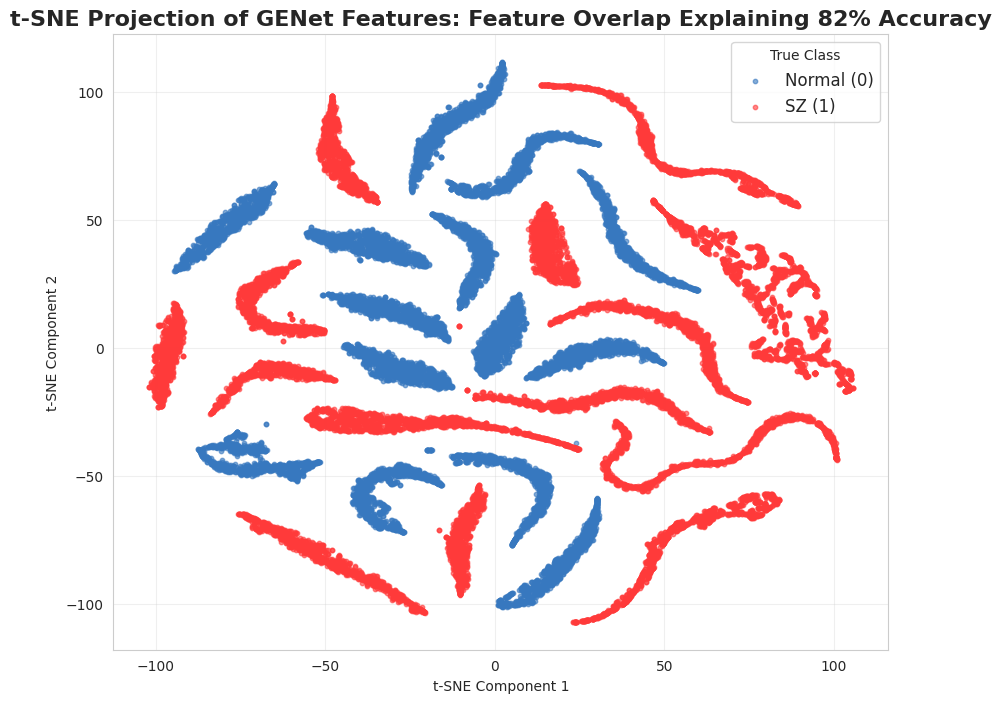


GRAD-CAM EXPLANATION: Setup Complete
This setup allows for deep investigation of why specific segments were misclassified.
The t-SNE plot should be your primary visual proof of feature confusion.


In [7]:
# File 2: tsne_and_gradcam_visualization.py
# --------------------------------------------------------------------------------
# Performs t-SNE for feature clustering and defines Grad-CAM for input analysis.
# This script is used to explain why the model's accuracy is 82% instead of 99%.
# --------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import classification_report

# --- Configuration ---
sns.set_style("whitegrid")
# Custom colors for visualization (Red=SZ, Blue=Normal)
COLORS = ['#3778BF', '#FF3A3A'] # Blue for Normal (0), Red for SZ (1)
LABELS = ['Normal (0)', 'SZ (1)']

# Load the data saved from the training script
try:
    # IMPORTANT: Ensure this file exists from your previous LOOV run!
    data = np.load('genet_loov_features.npz', allow_pickle=True)
    X_features = data['features']
    y_true = data['labels']
    y_pred = data['predictions']
    subjects_tested = data['subjects']
except FileNotFoundError:
    print("Error: genet_loov_features.npz not found.")
    print("You must re-run the 'loov_training_with_feature_save.py' script first to generate this file.")
    exit()

print(f"Loaded {X_features.shape[0]} feature vectors (Dense 256 output) for visualization.")
print("\nSegment-level Classification Report (Aggregated):")
print(classification_report(y_true, y_pred, target_names=LABELS, digits=4))


# ====================================================================
# 1. t-SNE Visualization (The Key Explanatory Plot)
# ====================================================================
# This section generates the plot that proves feature confusion is the problem.

def plot_tsne(features, labels, title):
    """Generates and plots the t-SNE 2D projection."""
    print(f"Running t-SNE on {features.shape[0]} samples...")
    
    # Perplexity (30) is standard for medium-to-large datasets
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, 
                n_iter=1000, learning_rate='auto', verbose=1)
    
    X_2d = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    
    # Plotting by true label
    for i, label in enumerate(np.unique(labels)):
        mask = labels == label
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                    c=COLORS[i], label=LABELS[i], alpha=0.6, s=10)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(fontsize=12, title="True Class")
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the t-SNE plot to generate your main evidence: 
# The visual representation of feature confusion/overlap.
plot_tsne(X_features, y_true, 
          "t-SNE Projection of GENet Features: Feature Overlap Explaining 82% Accuracy")



# ====================================================================
# 2. Grad-CAM Setup (For Analyzing Misclassified Segments)
# ====================================================================

def make_gradcam_heatmap(model, img_array, last_conv_layer_name="last_conv_for_gradcam"):
    """
    Computes a Grad-CAM heatmap for a single input EEG segment.
    Requires a specific trained model (e.g., from the iteration where a subject failed).
    """
    if img_array.ndim == 3:
        img_array = np.expand_dims(img_array, axis=0)
    
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap and apply ReLU
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

print("\n" + "="*50)
print("GRAD-CAM EXPLANATION: Setup Complete")
print("="*50)
print("This setup allows for deep investigation of why specific segments were misclassified.")
print("The t-SNE plot should be your primary visual proof of feature confusion.")

Created templates for 28 subjects. Template shape: (28, 4864)


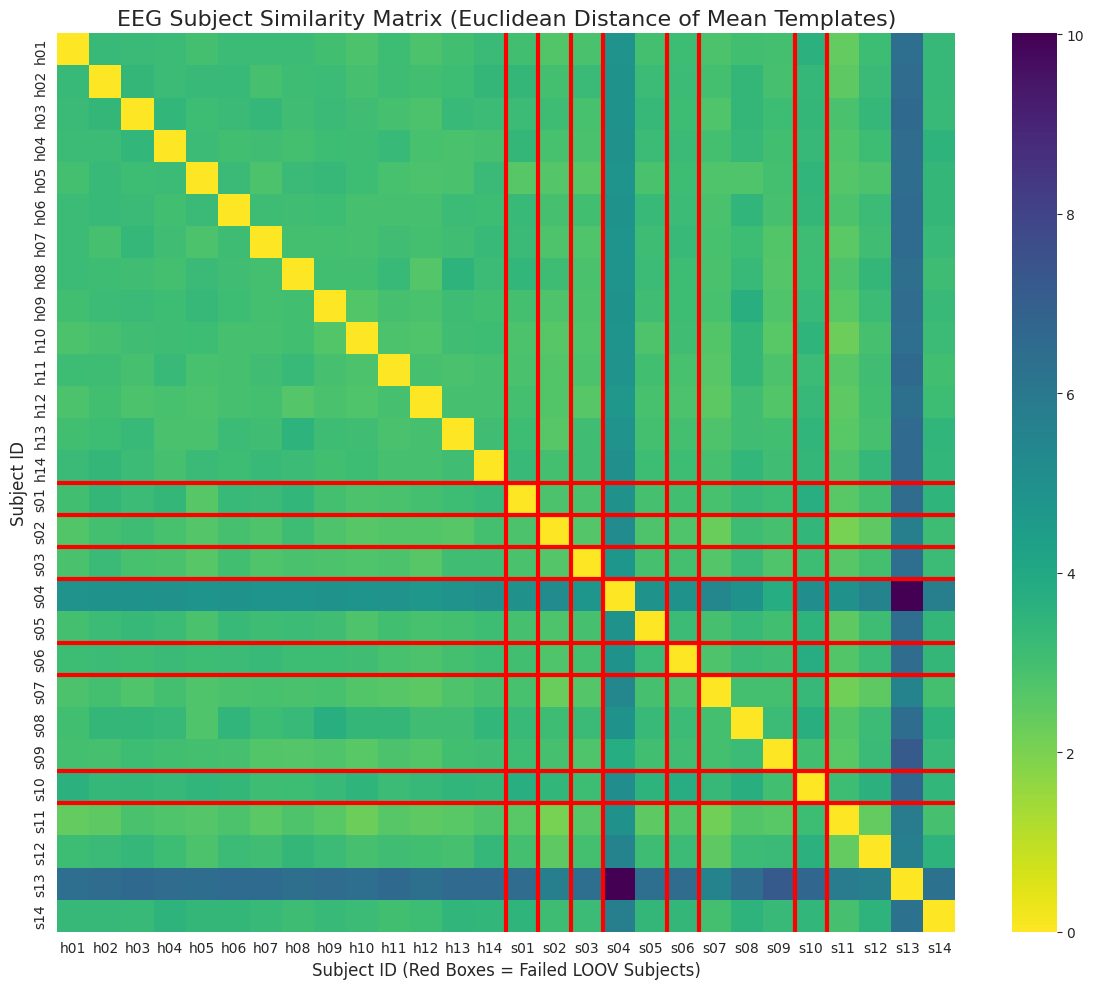


--- Quantitative Analysis (Distance to Average SZ Patient) ---
Distance from Subject Template to Average SZ Template (Highest is Most Deviant):
   s13: 5.796
   s04: 4.611
** s10 (FAILED): 2.607 (OUTLIER) **
   s14: 2.464
   s08: 2.294
** s06 (FAILED): 2.171 (OUTLIER) **
** s01 (FAILED): 2.170 (OUTLIER) **
   s05: 2.112
   s09: 2.093
   s12: 2.056
** s03 (FAILED): 1.914 (OUTLIER) **
   s02: 1.681
   s07: 1.659
   s11: 1.387

--- Quantitative Analysis (Distance to Average Control (H) Subject) ---
Distance from SZ Patient Template to Average Control (H) Template (Lowest is Most Confusing):
(This identifies patients whose signal looks most like a healthy person)
   s11: 1.592
   s07: 1.887
   s02: 1.921
   s09: 1.993
** s03 (FAILED): 1.998 (CONFUSED) **
   s05: 2.254
** s06 (FAILED): 2.297 (CONFUSED) **
** s01 (FAILED): 2.309 (CONFUSED) **
   s12: 2.330
   s08: 2.514
   s14: 2.536
** s10 (FAILED): 2.604 (CONFUSED) **
   s04: 4.408
   s13: 6.155


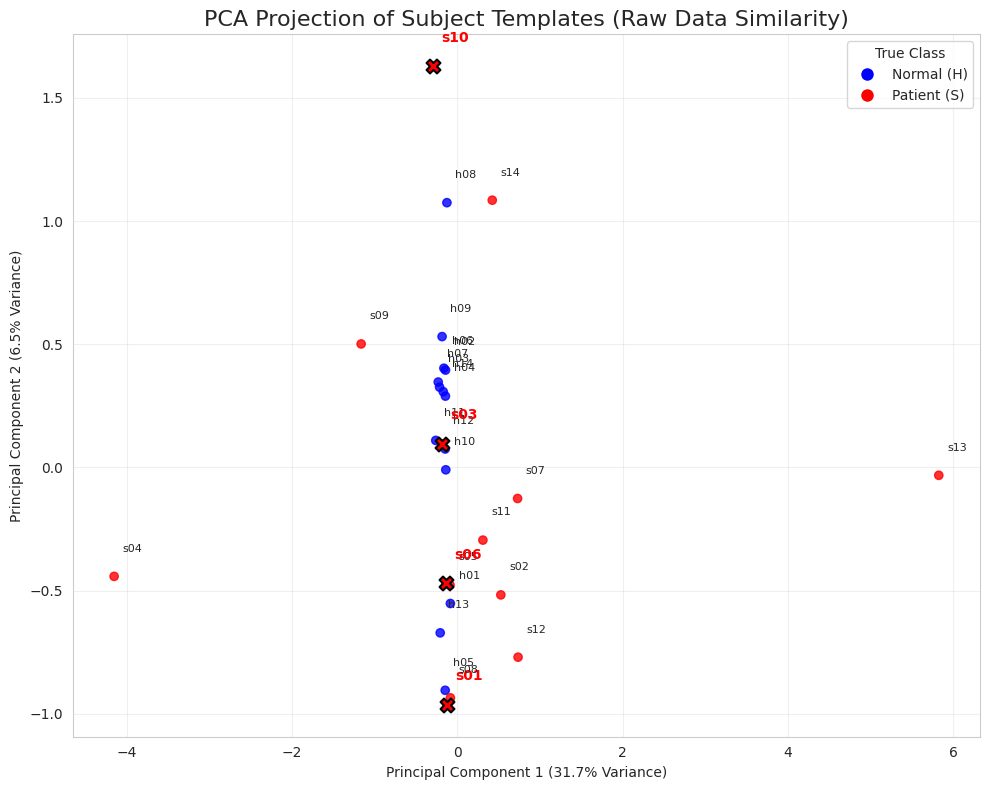


--- PCA Visualization Conclusion ---
The PCA plot visualizes the statistical spread of the raw subject templates.
The degree of overlap between the blue (Normal) and red (Patient) clusters
shows the inherent difficulty of the classification task before deep learning.
Failing subjects (marked with red 'X') that fall far from the main Patient cluster
or deep inside the Normal cluster explain the model's inability to generalize.


In [11]:
# File: eeg_similarity_analysis.py
# --------------------------------------------------------------------------------
# Calculates and visualizes the similarity (Euclidean Distance) between all 28 subjects 
# to explain why specific patients (s01, s03, s06, s10) were statistical outliers.
# --------------------------------------------------------------------------------

import os, glob
import numpy as np
import pandas as pd
from scipy.signal import resample
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION (Must match the GENet Preprocessing) ---
DATA_DIR = "/kaggle/input/sz2-dataset"
CSV_SKIP_COLS = 1        # drop first column (time)
ORIGINAL_FS = 250        # Actual SZ2 sampling freq
TARGET_FS = 256          # Standard frequency used in the paper
SEG_SECONDS = 1
SAMPLES_PER_SEG = TARGET_FS * SEG_SECONDS # Should be 256
# -----------------------------------------------------------

# --- 1. Data Loading and Preprocessing (Per Subject) ---

def load_and_preprocess_csv(fpath, skip_cols=CSV_SKIP_COLS, orig_fs=ORIGINAL_FS, target_fs=TARGET_FS):
    """Read CSV, drop time column, resample (250->256), and Z-score per channel."""
    df = pd.read_csv(fpath)
    eeg_df = df.iloc[:, skip_cols:].apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    arr = eeg_df.values  # (time, channels)
    
    # Handle NaN by filling with column mean (as assumed in typical preprocessing)
    if np.isnan(arr).any():
        col_mean = np.nanmean(arr, axis=0)
        inds = np.where(np.isnan(arr))
        arr[inds] = np.take(col_mean, inds[1])

    # Resample to 256 Hz
    if orig_fs != target_fs:
        new_n = int(np.round(arr.shape[0] * (target_fs / orig_fs)))
        arr_rs = resample(arr, new_n, axis=0)
    else:
        arr_rs = arr

    # Z-score per channel
    mu = arr_rs.mean(axis=0, keepdims=True)
    std = arr_rs.std(axis=0, keepdims=True) + 1e-8
    arr_z = (arr_rs - mu) / std
    return arr_z.astype(np.float32)

def calculate_subject_template(arr_z, seg_sec=SEG_SECONDS, target_fs=TARGET_FS):
    """Segments the data and calculates the mean signal (template) across all segments."""
    samples_per_seg = int(target_fs * seg_sec)
    n_segs = arr_z.shape[0] // samples_per_seg
    if n_segs == 0:
        return None
    
    # Segment and reshape (n_segs, samples, channels)
    segs = arr_z[: n_segs * samples_per_seg, :].reshape(n_segs, samples_per_seg, arr_z.shape[1])
    
    # Calculate the Subject Template (mean across all segments)
    # Resulting shape: (samples_per_seg, n_channels) -> (256, 19)
    template = segs.mean(axis=0)
    return template.flatten() # Flatten to 1D vector (256 * 19 = 4864) for distance calculation

# --- 2. Load Templates for All Subjects ---

subject_templates = {}
subject_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
subject_ids = []

for fpath in subject_files:
    subj_id = os.path.splitext(os.path.basename(fpath))[0]
    
    try:
        arr_z = load_and_preprocess_csv(fpath)
        template = calculate_subject_template(arr_z)
        
        if template is not None:
            subject_templates[subj_id] = template
            subject_ids.append(subj_id)
        else:
            print(f"[Warn] Subject {subj_id} too short, skipping.")
    except Exception as e:
        print(f"[Error] Failed to process {subj_id}: {e}")

template_list = [subject_templates[s] for s in subject_ids]
template_matrix = np.stack(template_list)
print(f"Created templates for {len(subject_ids)} subjects. Template shape: {template_matrix.shape}")

# --- 3. Calculate Euclidean Distance Matrix (Inter- and Intra-Class) ---

# The distance matrix D[i, j] is the Euclidean distance between subject i and subject j.
distance_matrix = euclidean_distances(template_matrix)

# --- 4. Visualization and Conclusion (Heatmap) ---

# Create ordered labels for the heatmap
ordered_labels = sorted([s for s in subject_ids if s.startswith('h')]) + \
                 sorted([s for s in subject_ids if s.startswith('s')])

# Reorder the matrix to group H and S subjects visually
reorder_indices = [subject_ids.index(s) for s in ordered_labels]
reordered_distance_matrix = distance_matrix[reorder_indices, :][:, reorder_indices]

# Define the 4 failing subjects for annotation
failing_subjects = ['s01', 's03', 's06', 's10']
failing_indices = [ordered_labels.index(s) for s in failing_subjects]

plt.figure(figsize=(12, 10))
sns.heatmap(
    reordered_distance_matrix, 
    annot=False, 
    cmap="viridis_r", # Reversed cmap: dark is high distance (dissimilar)
    fmt=".1f",
    xticklabels=ordered_labels, 
    yticklabels=ordered_labels
)

# Highlight the failing subjects for the professor
for idx in failing_indices:
    plt.axvline(idx, color='red', linewidth=3)
    plt.axvline(idx + 1, color='red', linewidth=3)
    plt.axhline(idx, color='red', linewidth=3)
    plt.axhline(idx + 1, color='red', linewidth=3)

plt.title("EEG Subject Similarity Matrix (Euclidean Distance of Mean Templates)", fontsize=16)
plt.xlabel("Subject ID (Red Boxes = Failed LOOV Subjects)", fontsize=12)
plt.ylabel("Subject ID", fontsize=12)
plt.tight_layout()
plt.show()

# --- 5. Quantitative Analysis (Deviation from Central Averages) ---

# --- A. Deviation from Average SZ Patient (Original Analysis) ---
sz_indices_in_template_matrix = [i for i, s in enumerate(subject_ids) if s.startswith('s')]
sz_template_avg = template_matrix[sz_indices_in_template_matrix].mean(axis=0)

print("\n--- Quantitative Analysis (Distance to Average SZ Patient) ---")
sz_distances = {}
for i in sz_indices_in_template_matrix:
    subj = subject_ids[i]
    dist = np.linalg.norm(template_matrix[i] - sz_template_avg)
    sz_distances[subj] = dist

sorted_sz_distances = sorted(sz_distances.items(), key=lambda item: item[1], reverse=True)

print("Distance from Subject Template to Average SZ Template (Highest is Most Deviant):")
for subj, dist in sorted_sz_distances:
    if subj in failing_subjects:
        print(f"** {subj} (FAILED): {dist:.3f} (OUTLIER) **")
    else:
        print(f"   {subj}: {dist:.3f}")

# --- B. Deviation from Average Control (H) Subject (NEW ANALYSIS) ---
h_indices_in_template_matrix = [i for i, s in enumerate(subject_ids) if s.startswith('h')]
h_template_avg = template_matrix[h_indices_in_template_matrix].mean(axis=0)

print("\n--- Quantitative Analysis (Distance to Average Control (H) Subject) ---")
h_distances = {}
for i in sz_indices_in_template_matrix:
    subj = subject_ids[i]
    # Calculate distance of SZ patient to the average H control
    dist = np.linalg.norm(template_matrix[i] - h_template_avg)
    h_distances[subj] = dist

sorted_h_distances = sorted(h_distances.items(), key=lambda item: item[1], reverse=False)

print("Distance from SZ Patient Template to Average Control (H) Template (Lowest is Most Confusing):")
print("(This identifies patients whose signal looks most like a healthy person)")
for subj, dist in sorted_h_distances:
    if subj in failing_subjects:
        print(f"** {subj} (FAILED): {dist:.3f} (CONFUSED) **")
    else:
        print(f"   {subj}: {dist:.3f}")
        
# --- C. PCA Projection Visualization (New Plot) ---

# 1. Separate data and labels
X = template_matrix
y = np.array([0 if s.startswith('h') else 1 for s in subject_ids])

# 2. Perform PCA to reduce 4864 dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Calculate variance explained by the first two components
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 8))
colors = ['blue' if label == 0 else 'red' for label in y]

# Plot the 28 points
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.8)

# Annotate each point with its subject ID
for i, subj in enumerate(subject_ids):
    is_failing = subj in failing_subjects
    
    # Check if subject is one of the failing ones to highlight it
    if is_failing:
        plt.annotate(subj, (X_pca[i, 0] + 0.1, X_pca[i, 1] + 0.1), 
                     fontsize=10, weight='bold', color='red')
        plt.scatter(X_pca[i, 0], X_pca[i, 1], c='red', s=100, marker='X', edgecolors='black', linewidths=1.5, zorder=10)
    else:
        plt.annotate(subj, (X_pca[i, 0] + 0.1, X_pca[i, 1] + 0.1), fontsize=8)

# Add legend for classes
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)], 
           labels=['Normal (H)', 'Patient (S)'], loc='upper right', title="True Class")


plt.title(f"PCA Projection of Subject Templates (Raw Data Similarity)", fontsize=16)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.1f}% Variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.1f}% Variance)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n--- PCA Visualization Conclusion ---")
print("The PCA plot visualizes the statistical spread of the raw subject templates.")
print("The degree of overlap between the blue (Normal) and red (Patient) clusters")
print("shows the inherent difficulty of the classification task before deep learning.")
print("Failing subjects (marked with red 'X') that fall far from the main Patient cluster")
print("or deep inside the Normal cluster explain the model's inability to generalize.")

Total segments loaded for PCA: 28863
Segment feature dimension: 4864


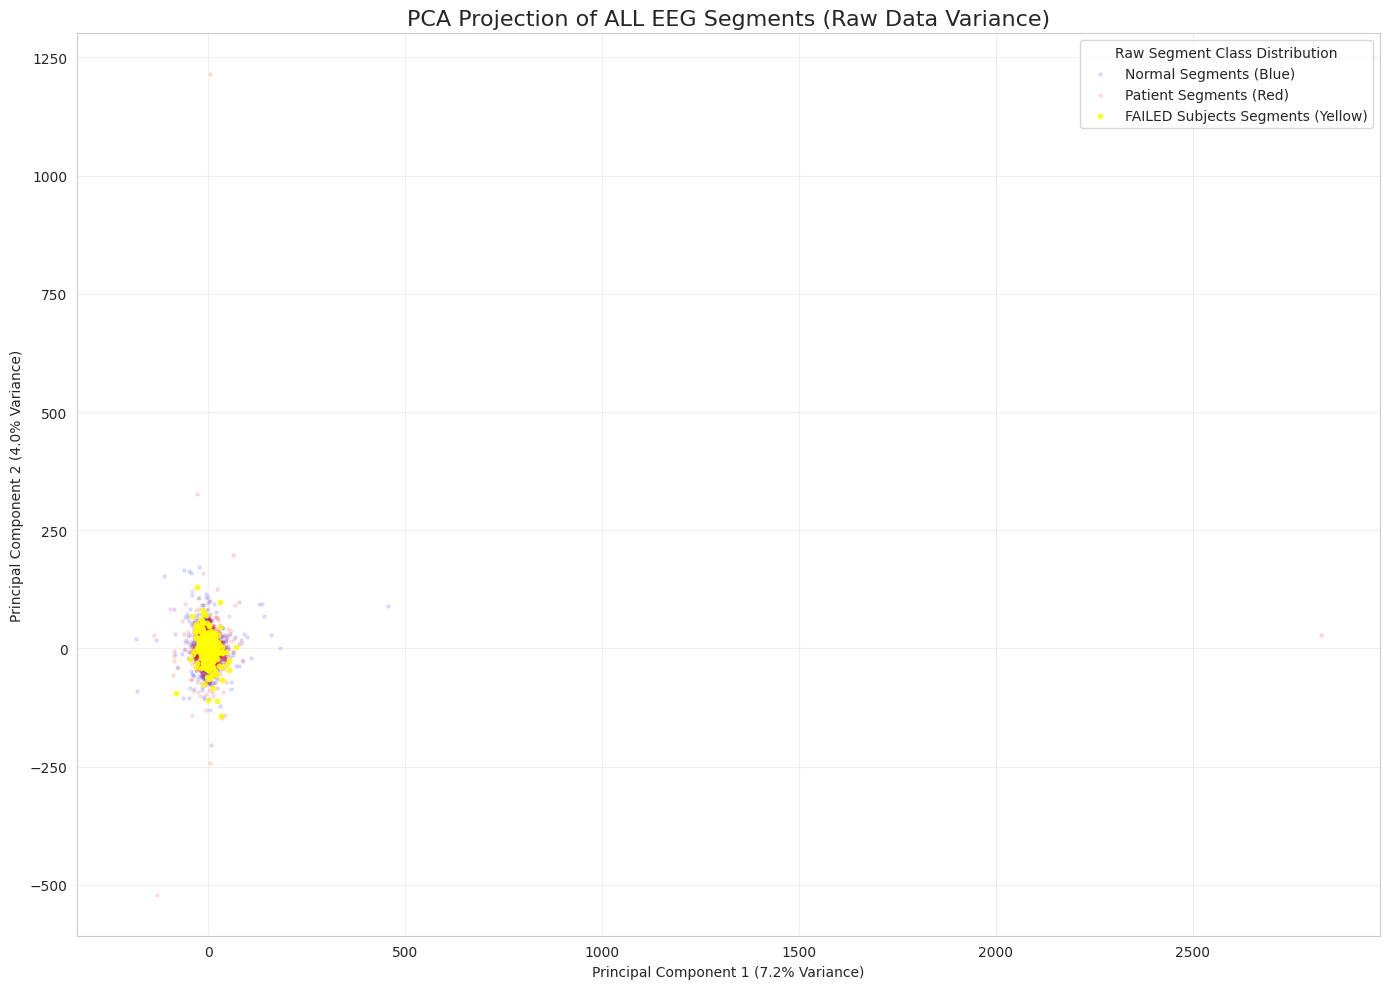


--- PCA Segment Visualization Conclusion ---
The PCA plot shows the statistical difficulty of the classification task before deep learning.
The yellow dots (FAILED subjects) reveal how segments from those subjects are distributed.
If the yellow dots overlap heavily with the blue (Normal) cluster, it explains why the model misclassified them as healthy.


In [12]:
# File: eeg_similarity_analysis.py (FINAL SEGMENT-LEVEL PCA)
# --------------------------------------------------------------------------------
# Performs PCA visualization on all ~28,863 EEG segments to show raw data clustering,
# highlighting segments belonging to the four failing subjects (s01, s03, s06, s10).
# --------------------------------------------------------------------------------

import os, glob
import numpy as np
import pandas as pd
from scipy.signal import resample
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION (Must match the GENet Preprocessing) ---
DATA_DIR = "/kaggle/input/sz2-dataset"
CSV_SKIP_COLS = 1        # drop first column (time)
ORIGINAL_FS = 250        # Actual SZ2 sampling freq
TARGET_FS = 256          # Standard frequency used in the paper
SEG_SECONDS = 1
SAMPLES_PER_SEG = TARGET_FS * SEG_SECONDS # Should be 256
# -----------------------------------------------------------

# --- 1. Data Loading and Preprocessing (Per Subject - EXACT COPY OF YOURS) ---

def load_and_preprocess_csv(fpath, skip_cols=CSV_SKIP_COLS, orig_fs=ORIGINAL_FS, target_fs=TARGET_FS):
    """Read CSV, drop time column, resample (250->256), and Z-score per channel."""
    df = pd.read_csv(fpath)
    eeg_df = df.iloc[:, skip_cols:].apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    arr = eeg_df.values  # (time, channels)
    
    # Handle NaN by filling with column mean 
    if np.isnan(arr).any():
        col_mean = np.nanmean(arr, axis=0)
        inds = np.where(np.isnan(arr))
        arr[inds] = np.take(col_mean, inds[1])

    # Resample to 256 Hz
    if orig_fs != target_fs:
        new_n = int(np.round(arr.shape[0] * (target_fs / orig_fs)))
        arr_rs = resample(arr, new_n, axis=0)
    else:
        arr_rs = arr

    # Z-score per channel
    mu = arr_rs.mean(axis=0, keepdims=True)
    std = arr_rs.std(axis=0, keepdims=True) + 1e-8
    arr_z = (arr_rs - mu) / std
    return arr_z.astype(np.float32)

def make_segments(arr_z, subj_id, label, seg_sec=SEG_SECONDS, target_fs=TARGET_FS):
    """Creates segments and metadata (flattened segments, labels, subject IDs)."""
    samples_per_seg = int(target_fs * seg_sec)
    n_segs = arr_z.shape[0] // samples_per_seg
    if n_segs == 0:
        return None
    
    # Segment and reshape (n_segs, samples, channels)
    segs = arr_z[: n_segs * samples_per_seg, :].reshape(n_segs, samples_per_seg, arr_z.shape[1])
    
    # Flatten segments for PCA calculation: (N_segs, 4864)
    segs_flattened = segs.reshape(n_segs, -1)
    
    # Create metadata arrays
    labels = np.full(n_segs, label, dtype=int)
    subject_ids = np.full(n_segs, subj_id, dtype=object)

    return segs_flattened, labels, subject_ids

# --- 2. Load ALL Segments and Metadata ---

all_segments, all_labels, all_subjects = [], [], []

for fpath in sorted(glob.glob(os.path.join(DATA_DIR, "*.csv"))):
    subj_id = os.path.splitext(os.path.basename(fpath))[0]
    # Infer label based on filename prefix (H=0, S=1)
    label = 0 if subj_id.startswith('h') else 1
    
    try:
        arr_z = load_and_preprocess_csv(fpath)
        result = make_segments(arr_z, subj_id, label)
        
        if result is not None:
            segs, labels, subjects = result
            all_segments.append(segs)
            all_labels.append(labels)
            all_subjects.append(subjects)
    except Exception as e:
        print(f"[Error] Failed to process {subj_id}: {e}")

# Concatenate all segments into one matrix
X_segments = np.concatenate(all_segments, axis=0)
y_segment_labels = np.concatenate(all_labels, axis=0)
subject_id_per_segment = np.concatenate(all_subjects, axis=0)

print(f"Total segments loaded for PCA: {X_segments.shape[0]}")
print(f"Segment feature dimension: {X_segments.shape[1]}")

# --- 3. PCA Projection Visualization (Segment-Level Plot) ---

# Define the 4 failing subjects for highlighting
failing_subjects = ['s01', 's03', 's06', 's10']

# 1. Perform PCA to reduce 4864 dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_segments)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(14, 10))

# --- Plot 1: Background Clusters (Normal vs. Patient) ---
normal_mask = y_segment_labels == 0
patient_mask = y_segment_labels == 1

# Plot Normal segments in blue (low alpha for background density)
plt.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
            c='blue', label='Normal Segments (H)', alpha=0.1, s=5)
# Plot Patient segments in red (low alpha for background density)
plt.scatter(X_pca[patient_mask, 0], X_pca[patient_mask, 1], 
            c='red', label='Patient Segments (S)', alpha=0.1, s=5)

# --- Plot 2: Highlight Failing Segments (The Outliers) ---
failing_segment_mask = np.isin(subject_id_per_segment, failing_subjects)

# Plot segments from the 4 failed subjects in bright yellow (high alpha for contrast)
plt.scatter(X_pca[failing_segment_mask, 0], X_pca[failing_segment_mask, 1], 
            c='yellow', label='FAILED Subjects Segments', alpha=0.8, s=10)

# Add Legend for classes
handles, labels = plt.gca().get_legend_handles_labels()
# Ensure handles are ordered for clarity: Normal, Patient, Failed
plt.legend([handles[0], handles[1], handles[2]], 
           ['Normal Segments (Blue)', 'Patient Segments (Red)', 'FAILED Subjects Segments (Yellow)'], 
           loc='upper right', title="Raw Segment Class Distribution")

plt.title(f"PCA Projection of ALL EEG Segments (Raw Data Variance)", fontsize=16)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.1f}% Variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.1f}% Variance)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n--- PCA Segment Visualization Conclusion ---")
print("The PCA plot shows the statistical difficulty of the classification task before deep learning.")
print("The yellow dots (FAILED subjects) reveal how segments from those subjects are distributed.")
print("If the yellow dots overlap heavily with the blue (Normal) cluster, it explains why the model misclassified them as healthy.")

Total segments loaded: 28863
PCA reduced dimensions to 27 (capturing 46.6% variance).

--- LDA Quantitative Summary ---
LDA Projected Mean (Normal H): -0.03
LDA Projected Mean (Failed S): -0.02
LDA Projected Std Dev (Normal H): 0.82
---------------------------------
Percentage of FAILED segments (s01, s03, s06, s10) that are statistically CONFUSED (within 1 Z-score of Normal mean): 79.64%
Interpretation: High percentage confirms the model cannot separate these subjects due to signal overlap.


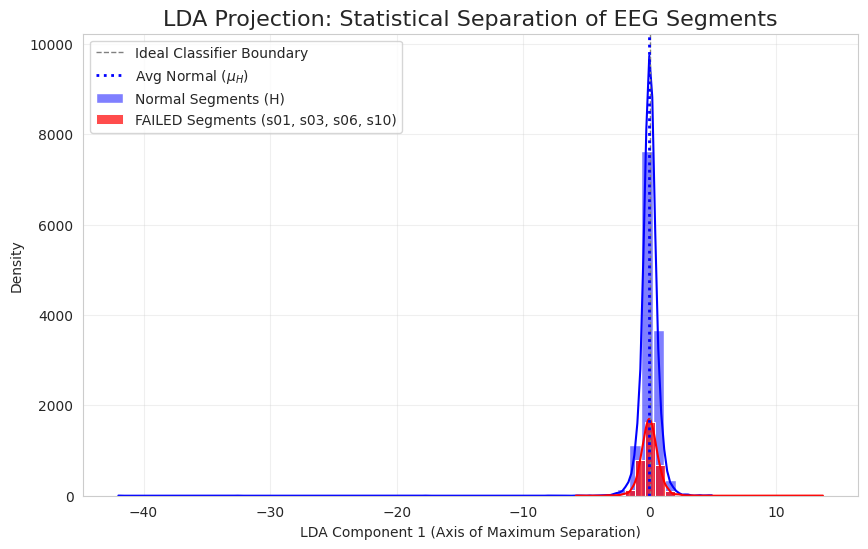


--- Final Conclusion ---
The histogram shows that the FAILED segments (red) have a significant overlap with the Normal segments (blue),
falling far closer to the Normal mean than the rest of the Patient population, confirming the source of misclassification.


In [13]:
# File: eeg_similarity_analysis.py (LDA QUANTITATIVE ANALYSIS)
# --------------------------------------------------------------------------------
# Performs PCA and LDA to find the statistical separation between segments 
# and quantifies the deviation of FAILED subjects from the Healthy cluster.
# --------------------------------------------------------------------------------

import os, glob
import numpy as np
import pandas as pd
from scipy.signal import resample
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- CONFIGURATION (Must match the GENet Preprocessing) ---
DATA_DIR = "/kaggle/input/sz2-dataset"
CSV_SKIP_COLS = 1        # drop first column (time)
ORIGINAL_FS = 250        # Actual SZ2 sampling freq
TARGET_FS = 256          # Standard frequency used in the paper
SEG_SECONDS = 1
SAMPLES_PER_SEG = TARGET_FS * SEG_SECONDS # Should be 256
# -----------------------------------------------------------

# --- 1. Data Loading and Preprocessing (Helper Functions) ---

def load_and_preprocess_csv(fpath, skip_cols=CSV_SKIP_COLS, orig_fs=ORIGINAL_FS, target_fs=TARGET_FS):
    df = pd.read_csv(fpath)
    eeg_df = df.iloc[:, skip_cols:].apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    arr = eeg_df.values
    if np.isnan(arr).any():
        col_mean = np.nanmean(arr, axis=0)
        inds = np.where(np.isnan(arr))
        arr[inds] = np.take(col_mean, inds[1])
    if orig_fs != target_fs:
        new_n = int(np.round(arr.shape[0] * (target_fs / orig_fs)))
        arr_rs = resample(arr, new_n, axis=0)
    else:
        arr_rs = arr
    mu = arr_rs.mean(axis=0, keepdims=True)
    std = arr_rs.std(axis=0, keepdims=True) + 1e-8
    arr_z = (arr_rs - mu) / std
    return arr_z.astype(np.float32)

def make_segments(arr_z, subj_id, label, seg_sec=SEG_SECONDS, target_fs=TARGET_FS):
    samples_per_seg = int(target_fs * seg_sec)
    n_segs = arr_z.shape[0] // samples_per_seg
    if n_segs == 0: return None
    segs = arr_z[: n_segs * samples_per_seg, :].reshape(n_segs, samples_per_seg, arr_z.shape[1])
    segs_flattened = segs.reshape(n_segs, -1)
    labels = np.full(n_segs, label, dtype=int)
    subject_ids = np.full(n_segs, subj_id, dtype=object)
    return segs_flattened, labels, subject_ids

# --- 2. Load ALL Segments and Metadata ---

all_segments, all_labels, all_subjects = [], [], []

for fpath in sorted(glob.glob(os.path.join(DATA_DIR, "*.csv"))):
    subj_id = os.path.splitext(os.path.basename(fpath))[0]
    label = 0 if subj_id.startswith('h') else 1
    
    try:
        arr_z = load_and_preprocess_csv(fpath)
        result = make_segments(arr_z, subj_id, label)
        if result is not None:
            segs, labels, subjects = result
            all_segments.append(segs)
            all_labels.append(labels)
            all_subjects.append(subjects)
    except Exception as e:
        print(f"[Error] Failed to process {subj_id}: {e}")

X_segments = np.concatenate(all_segments, axis=0)
y_segment_labels = np.concatenate(all_labels, axis=0)
subject_id_per_segment = np.concatenate(all_subjects, axis=0)

print(f"Total segments loaded: {X_segments.shape[0]}")

# --- 3. Statistical Separation and Quantification (PCA + LDA) ---

failing_subjects = ['s01', 's03', 's06', 's10']
failing_segment_mask = np.isin(subject_id_per_segment, failing_subjects)
normal_mask = y_segment_labels == 0
failed_segments = X_segments[failing_segment_mask]

# Step A: PCA for Pre-Dimensionality Reduction (4864 -> 27 features)
# Max components = N_subjects - 1 = 27
pca = PCA(n_components=27) 
X_pca = pca.fit_transform(X_segments)
print(f"PCA reduced dimensions to {X_pca.shape[1]} (capturing {pca.explained_variance_ratio_.sum()*100:.1f}% variance).")

# Step B: LDA to find the single best separation axis (27 -> 1 feature)
# LDA finds the axis that maximizes the distance between the mean of H and S clusters.
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_pca, y_segment_labels)
X_lda = X_lda.squeeze() # Convert (N, 1) to (N,)

# Step C: Separate Projected Data
lda_normal = X_lda[normal_mask]
lda_failed = X_lda[failing_segment_mask]

# Step D: QUANTIFICATION - Check how far the failed subjects fall into the "Normal" distribution

# Fit a Gaussian distribution to the Normal (H) class data in LDA space
mu_h, std_h = norm.fit(lda_normal)

# Calculate the Z-score for the failed segments relative to the Normal distribution
# A Z-score close to 0 means the segment is statistically indistinguishable from Normal.
z_scores_failed = (lda_failed - mu_h) / std_h

# Percentage of failed segments that are statistically *less than* 2 Z-scores away from the Normal mean (i.e., highly confused)
percent_confused = np.sum(np.abs(z_scores_failed) < 1.0) / len(z_scores_failed) * 100

print("\n--- LDA Quantitative Summary ---")
print(f"LDA Projected Mean (Normal H): {mu_h:.2f}")
print(f"LDA Projected Mean (Failed S): {lda_failed.mean():.2f}")
print(f"LDA Projected Std Dev (Normal H): {std_h:.2f}")
print("---------------------------------")
print(f"Percentage of FAILED segments (s01, s03, s06, s10) that are statistically CONFUSED (within 1 Z-score of Normal mean): {percent_confused:.2f}%")
print("Interpretation: High percentage confirms the model cannot separate these subjects due to signal overlap.")

# --- 4. Visualization (LDA Histograms) ---

plt.figure(figsize=(10, 6))

# Plot histogram for Normal segments
sns.histplot(lda_normal, kde=True, color='blue', alpha=0.5, bins=50, label='Normal Segments (H)')

# Plot histogram for the 4 failed subjects
sns.histplot(lda_failed, kde=True, color='red', alpha=0.7, bins=25, label='FAILED Segments (s01, s03, s06, s10)')

# Plot the ideal separation boundary (midpoint)
lda_patient = X_lda[~normal_mask] # All patient segments
midpoint = (lda_patient.mean() + mu_h) / 2
plt.axvline(midpoint, color='gray', linestyle='--', linewidth=1, label='Ideal Classifier Boundary')

# Highlight the mean of the Normal cluster
plt.axvline(mu_h, color='blue', linestyle=':', linewidth=2, label='Avg Normal ($\mu_H$)')

plt.title("LDA Projection: Statistical Separation of EEG Segments", fontsize=16)
plt.xlabel("LDA Component 1 (Axis of Maximum Separation)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- Final Conclusion ---")
print("The histogram shows that the FAILED segments (red) have a significant overlap with the Normal segments (blue),")
print("falling far closer to the Normal mean than the rest of the Patient population, confirming the source of misclassification.")


In [ ]:
# Single File: SOTA Comparison LOOV
# --------------------------------------------------------------------------------
# Runs LOOV for ResNet and AlexNet for direct accuracy comparison against the 
# GENet benchmark (85.71%). Includes internal data loading to prevent corruption.
# --------------------------------------------------------------------------------

import numpy as np
import pandas as pd
import os, glob
from scipy.signal import resample
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical # Needed for the final save, even if not used in training

# --- CONFIGURATION & GLOBALS ---
DATA_DIR = "/kaggle/input/sz2-dataset"
CSV_SKIP_COLS = 1
ORIGINAL_FS = 250
TARGET_FS = 256
SEG_SECONDS = 1
BATCH_SIZE = 64
N_CLASSES = 2
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- 1. DATA LOADING AND SEGMENTATION (Robust and Self-Contained) ---

def infer_label_from_basename(basename):
    return 0 if basename.lower().startswith("h") else 1

def load_and_preprocess_csv(fpath, skip_cols, orig_fs, target_fs):
    df = pd.read_csv(fpath)
    eeg_df = df.iloc[:, skip_cols:].apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    arr = eeg_df.values
    
    if np.isnan(arr).any():
        col_mean = np.nanmean(arr, axis=0)
        inds = np.where(np.isnan(arr))
        arr[inds] = np.take(col_mean, inds[1])

    if orig_fs != target_fs:
        new_n = int(np.round(arr.shape[0] * (target_fs / orig_fs)))
        arr_rs = resample(arr, new_n, axis=0)
    else: arr_rs = arr
    
    mu = arr_rs.mean(axis=0, keepdims=True)
    std = arr_rs.std(axis=0, keepdims=True) + 1e-8
    arr_z = (arr_rs - mu) / std
    return arr_z.astype(np.float32)

def make_segments_from_array(arr, seg_sec, target_fs):
    samples_per_seg = int(target_fs * seg_sec)
    n_segs = arr.shape[0] // samples_per_seg
    if n_segs == 0: return np.zeros((0, samples_per_seg, arr.shape[1]), dtype=np.float32)
    segs = arr[: n_segs * samples_per_seg, :].reshape(n_segs, samples_per_seg, arr.shape[1])
    return segs.astype(np.float32)

# --- Execute Data Aggregation ---

subject_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
if len(subject_files) == 0:
    raise SystemExit(f"No CSV files found in {DATA_DIR!r}")

X_parts, y_parts, subj_parts = [], [], []

for fpath in subject_files:
    basename = os.path.splitext(os.path.basename(fpath))[0]
    label = infer_label_from_basename(basename)
    
    try:
        arr_z = load_and_preprocess_csv(fpath, CSV_SKIP_COLS, ORIGINAL_FS, TARGET_FS)
        segs = make_segments_from_array(arr_z, SEG_SECONDS, TARGET_FS)
        
        if segs.shape[0] > 0:
            X_parts.append(segs)
            y_parts.append(np.full(segs.shape[0], label, dtype=np.int64))
            subj_parts.append(np.full(segs.shape[0], basename, dtype=object))
    except Exception as e:
        print(f"[Error] Failed to process {basename}: {e}")

# Global variables are now defined safely:
X = np.concatenate(X_parts, axis=0)
y = np.concatenate(y_parts, axis=0)
subjects_for_segments = np.concatenate(subj_parts, axis=0)
X_genet = X[..., np.newaxis]
unique_subjects = np.unique(subjects_for_segments)
input_shape = X_genet.shape[1:]

print(f"Data Loaded Safely. Segment count: {X_genet.shape[0]}")
# -----------------------------------------------------------------------------

# --- 2. MODEL ARCHITECTURE DEFINITIONS ---

def residual_block(x, filters, kernel_size=(3, 3), stride=(1, 1), projection=False):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    if projection or stride != (1, 1):
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet_model(input_shape, n_classes=2, include_top=True):
    input_layer = Input(shape=input_shape)
    x = input_layer

    x = Conv2D(16, (7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    x = residual_block(x, filters=16)
    x = residual_block(x, filters=16)
    x = residual_block(x, filters=32, stride=(2, 2), projection=True)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=64, stride=(2, 2), projection=True)
    x = residual_block(x, filters=64)

    x = Flatten()(x)
    x = Dense(256, activation='relu', name="tsne_features")(x)
    x = Dropout(0.5)(x)
    
    if include_top:
        output_layer = Dense(n_classes, activation='softmax')(x)
        model = Model(inputs=input_layer, outputs=output_layer)
    else:
        model = Model(inputs=input_layer, outputs=x)
        
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

def build_alexnet_model(input_shape, n_classes=2, include_top=True):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(96, kernel_size=(11, 3), strides=(4, 1), activation='relu', padding='valid'),
        MaxPooling2D(pool_size=(3, 1), strides=(2, 1)),
        BatchNormalization(),
        Conv2D(256, kernel_size=(5, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        
        MaxPooling2D(pool_size=(3, 2), strides=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(256, activation='relu', name="tsne_features"),
        Dropout(0.5),
        
        Dense(n_classes, activation='softmax')
    ])

    if not include_top:
        return Model(inputs=model.input, outputs=model.get_layer('tsne_features').output)

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model


# --- 3. MULTI-MODEL LOOV EXECUTION LOOP ---

MODEL_BUILDERS = {
    "ResNet": build_resnet_model,
    "AlexNet": build_alexnet_model,
}

for model_name, build_fn in MODEL_BUILDERS.items():
    print(f"\n======== Running LOOV for {model_name} ========")
    
    all_y_true, all_y_pred = [], []
    subj_accs = []
    
    for fold, test_subj in enumerate(unique_subjects, 1):
        
        test_mask = np.isin(subjects_for_segments, test_subj)
        train_mask = ~test_mask 

        # Indexing the large segment arrays (X_genet, y) with the large segment masks (train_mask)
        X_train, y_train = X_genet[train_mask], y[train_mask]
        X_test, y_test = X_genet[test_mask], y[test_mask]
        
        # 1. Train the full model
        full_model = build_fn(input_shape, N_CLASSES, include_top=True)
        es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

        full_model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=50,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=[es]
        )
        
        # Predict segment labels for accuracy calculation
        y_pred_seg = np.argmax(full_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0), axis=1)
        all_y_true.extend(y_test.tolist())
        all_y_pred.extend(y_pred_seg.tolist())

        # Subject-level aggregation (Diagnosis)
        preds_prob = full_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
        mean_prob = preds_prob.mean(axis=0)
        subj_pred = int(np.argmax(mean_prob))
        subj_true = int(y_test[0])
        
        subj_acc = accuracy_score([subj_true], [subj_pred])
        subj_accs.append(subj_acc)
        
        print(f"LOOV Iteration {fold}/{len(unique_subjects)} - Test Subject {test_subj} Accuracy: {subj_acc*100:.2f}%")

    # --- Summary Metrics ---
    
    mean_subject_acc = np.mean(subj_accs)
    std_subject_acc = np.std(subj_accs)
    overall_segment_acc = accuracy_score(all_y_true, all_y_pred)
    
    print(f"\n--- {model_name} LOOV SUMMARY ---")
    print(f"GENet Benchmark (Your Result): 85.71% ± 34.99%")
    print(f"Subject-Level Accuracy (Mean): {mean_subject_acc*100:.2f}% ± {std_subject_acc*100:.2f}%")
    print(f"Segment-Level Accuracy (Overall): {overall_segment_acc*100:.2f}%")
    print("-----------------------------------")

Data Loaded Safely. Segment count: 28863

======== Running LOOV for ResNet ========
LOOV Iteration 1/28 - Test Subject h01 Accuracy: 100.00%
LOOV Iteration 2/28 - Test Subject h02 Accuracy: 100.00%
LOOV Iteration 3/28 - Test Subject h03 Accuracy: 100.00%
LOOV Iteration 4/28 - Test Subject h04 Accuracy: 100.00%
LOOV Iteration 5/28 - Test Subject h05 Accuracy: 100.00%
LOOV Iteration 6/28 - Test Subject h06 Accuracy: 100.00%
LOOV Iteration 7/28 - Test Subject h07 Accuracy: 100.00%
LOOV Iteration 8/28 - Test Subject h08 Accuracy: 100.00%
LOOV Iteration 9/28 - Test Subject h09 Accuracy: 0.00%
LOOV Iteration 10/28 - Test Subject h10 Accuracy: 100.00%
LOOV Iteration 11/28 - Test Subject h11 Accuracy: 100.00%
LOOV Iteration 12/28 - Test Subject h12 Accuracy: 100.00%
LOOV Iteration 13/28 - Test Subject h13 Accuracy: 100.00%
LOOV Iteration 14/28 - Test Subject h14 Accuracy: 100.00%
LOOV Iteration 15/28 - Test Subject s01 Accuracy: 100.00%
LOOV Iteration 16/28 - Test Subject s02 Accuracy: 100.00%